# VAEP 성능 분석 노트북

이 노트북은 VAEP 파이프라인의 결과를 분석하고 성능 지표를 계산합니다.

## 분석 내용
1. 데이터 로드 및 기본 통계
2. 선수별 VAEP 분포 분석
3. 포지션별 VAEP 비교
4. 상위/하위 선수 식별
5. 경기당 VAEP 변동성 분석
6. 경기별 VAEP 추이
7. 요약 통계
8. **골키퍼 전용 분석** ⚽ (NEW)
9. **전체 선수 시각화** 📊 (NEW)
   - 모든 선수 산점도 (골키퍼 vs 필드 플레이어)
   - 포지션별 VAEP 분포
   - Top 50 전체 랭킹

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("라이브러리 로드 완료")

라이브러리 로드 완료


## 1. 데이터 로드

In [ ]:
# 데이터 경로 설정
from pathlib import Path

# 모델 버전 지정 (latest 또는 특정 버전)
MODEL_VERSION = "20251127_020923"  # 또는 "latest"로 변경하여 최신 버전 사용
DATA_DIR = Path(f'../models/{MODEL_VERSION}/results')

# Player-match VAEP 로드
player_match_df = pd.read_csv(DATA_DIR / 'player_match_vaep_england.csv')
print(f"Player-match data shape: {player_match_df.shape}")
print(f"Columns: {player_match_df.columns.tolist()}")
print("\nFirst few rows:")
player_match_df.head()


Player-match data shape: (10412, 7)
Columns: ['playerId', 'matchId', 'teamId', 'vaep', 'num_events', 'minutes_played', 'vaep_per90']

First few rows:


,playerId,matchId,teamId,vaep,num_events,minutes_played,vaep_per90
0,0,2499719,1609,-0.991417,62,90.0,-0.991417
1,0,2499719,1631,-0.006741,102,90.0,-0.006741
2,0,2499720,1625,0.004141,22,90.0,0.004141
3,0,2499720,1651,-0.003683,92,90.0,-0.003683
4,0,2499721,1610,-0.000352,29,90.0,-0.000352


In [13]:
# Player-season VAEP 로드
player_season_df = pd.read_csv(DATA_DIR / 'player_season_vaep_england.csv')
print(f"Player-season data shape: {player_season_df.shape}")
print(f"Columns: {player_season_df.columns.tolist()}")
print("\nFirst few rows:")
player_season_df.head()

Player-season data shape: (477, 7)
Columns: ['playerId', 'matches_played', 'season_vaep_total', 'season_vaep_per90_avg', 'minutes_played', 'num_events', 'season_vaep_per_match']

First few rows:


,playerId,matches_played,season_vaep_total,season_vaep_per90_avg,minutes_played,num_events,season_vaep_per_match
0,25604,1,1.003354,1.003354,90.0,56,1.003354
1,8717,37,21.056098,0.569021,3195.0,1857,0.569084
2,8325,25,13.995449,0.559839,2160.0,1296,0.559818
3,120353,36,16.058066,0.501538,3105.0,2132,0.446057
4,8374,4,0.994782,0.497393,270.0,145,0.248695


## 2. 기본 통계 분석

In [14]:
# Player-match VAEP 기본 통계
print("=" * 80)
print("Player-Match VAEP 기본 통계")
print("=" * 80)
print(f"\n총 선수-경기 조합 수: {len(player_match_df):,}")
print(f"고유 선수 수: {player_match_df['playerId'].nunique():,}")
print(f"고유 경기 수: {player_match_df['matchId'].nunique():,}")
print(f"\nVAEP 통계:")
print(player_match_df[['vaep', 'vaep_per90', 'num_events', 'minutes_played']].describe())

Player-Match VAEP 기본 통계

총 선수-경기 조합 수: 10,412
고유 선수 수: 477
고유 경기 수: 380

VAEP 통계:
               vaep    vaep_per90    num_events  minutes_played
count  10412.000000  10412.000000  10412.000000    10412.000000
mean       0.008157      0.011994     58.965425       80.560891
std        0.409822      0.461102     31.552360       18.321991
min       -2.991918     -2.991918      1.000000       45.000000
25%       -0.004066     -0.004434     36.000000       90.000000
50%       -0.000202     -0.000287     60.000000       90.000000
75%        0.003318      0.003894     80.000000       90.000000
max        3.992271      4.012537    223.000000       90.000000


In [18]:
# Player-season VAEP 기본 통계
print("=" * 80)
print("Player-Season VAEP 기본 통계")
print("=" * 80)
print(f"\n총 선수 수: {len(player_season_df):,}")
print(f"\nVAEP 통계:")

# 실제 존재하는 컬럼만 사용
numeric_cols = player_season_df.select_dtypes(include=[np.number]).columns.tolist()
print(player_season_df[numeric_cols].describe())


Player-Season VAEP 기본 통계

총 선수 수: 477

VAEP 통계:
            playerId  matches_played  season_vaep_total  \
count     477.000000      477.000000         477.000000   
mean    91695.691824       21.828092           0.178060   
std    131893.152848       35.806316           4.291056   
min         0.000000        1.000000         -69.225748   
25%      8284.000000       10.000000          -1.014609   
50%     15474.000000       23.000000          -0.001168   
75%    134102.000000       30.000000           0.968394   
max    532949.000000      760.000000          21.056098   

       season_vaep_per90_avg  minutes_played    num_events  \
count             477.000000      477.000000    477.000000   
mean                0.005735     1758.490566   1287.102725   
std                 0.151332     3222.044608   2324.269477   
min                -1.004512       45.000000      1.000000   
25%                -0.053996      720.000000    345.000000   
50%                -0.000449     1710.000000   1

## 3. VAEP 분포 시각화

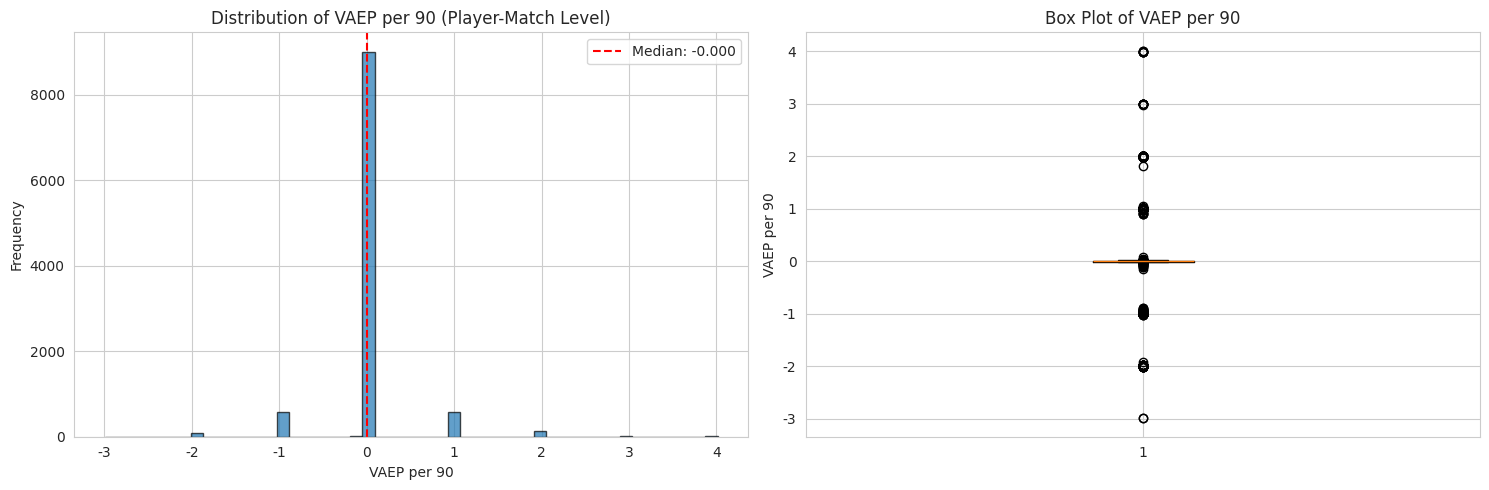

Mean VAEP per 90: 0.0120
Median VAEP per 90: -0.0003
Std VAEP per 90: 0.4611


In [16]:
# VAEP per 90 분포 (Player-match 레벨)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(player_match_df['vaep_per90'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('VAEP per 90')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of VAEP per 90 (Player-Match Level)')
axes[0].axvline(player_match_df['vaep_per90'].median(), color='red', linestyle='--', label=f'Median: {player_match_df["vaep_per90"].median():.3f}')
axes[0].legend()

# Box plot
axes[1].boxplot(player_match_df['vaep_per90'], vert=True)
axes[1].set_ylabel('VAEP per 90')
axes[1].set_title('Box Plot of VAEP per 90')

plt.tight_layout()
plt.show()

print(f"Mean VAEP per 90: {player_match_df['vaep_per90'].mean():.4f}")
print(f"Median VAEP per 90: {player_match_df['vaep_per90'].median():.4f}")
print(f"Std VAEP per 90: {player_match_df['vaep_per90'].std():.4f}")

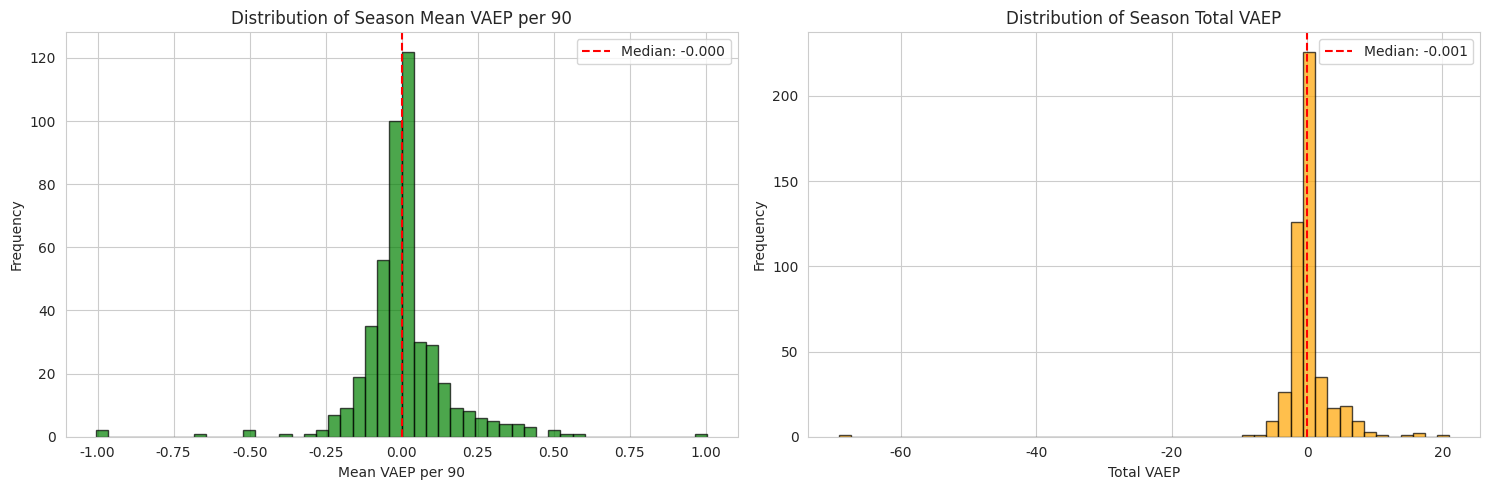

In [19]:
# Season-level VAEP 분포
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mean VAEP per 90 분포 - 실제 컬럼명 사용
vaep_col = 'season_vaep_per90_avg' if 'season_vaep_per90_avg' in player_season_df.columns else 'mean_vaep_per90'
total_col = 'season_vaep_total' if 'season_vaep_total' in player_season_df.columns else 'total_vaep'

axes[0].hist(player_season_df[vaep_col], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Mean VAEP per 90')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Season Mean VAEP per 90')
axes[0].axvline(player_season_df[vaep_col].median(), color='red', linestyle='--', label=f'Median: {player_season_df[vaep_col].median():.3f}')
axes[0].legend()

# Total VAEP 분포
axes[1].hist(player_season_df[total_col], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Total VAEP')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Season Total VAEP')
axes[1].axvline(player_season_df[total_col].median(), color='red', linestyle='--', label=f'Median: {player_season_df[total_col].median():.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()


## 4. 상위 선수 분석

In [20]:
# 최소 경기 수 필터 (신뢰성을 위해)
min_matches = 10
matches_col = 'matches_played' if 'matches_played' in player_season_df.columns else 'num_matches'
qualified_players = player_season_df[player_season_df[matches_col] >= min_matches].copy()

print(f"최소 {min_matches}경기 이상 출전 선수: {len(qualified_players):,}명 (전체 {len(player_season_df):,}명)")


최소 10경기 이상 출전 선수: 360명 (전체 477명)


In [21]:
# Top 20 선수 (mean VAEP per 90 기준)
vaep_col = 'season_vaep_per90_avg' if 'season_vaep_per90_avg' in player_season_df.columns else 'mean_vaep_per90'
total_col = 'season_vaep_total' if 'season_vaep_total' in player_season_df.columns else 'total_vaep'
matches_col = 'matches_played' if 'matches_played' in player_season_df.columns else 'num_matches'
events_col = 'num_events' if 'num_events' in player_season_df.columns else 'total_events'

top_20_vaep_per90 = qualified_players.nlargest(20, vaep_col)

print("=" * 80)
print(f"Top 20 Players by Mean VAEP per 90 (min {min_matches} matches)")
print("=" * 80)
print(top_20_vaep_per90[['playerId', vaep_col, total_col, matches_col, events_col]].to_string(index=False))


Top 20 Players by Mean VAEP per 90 (min 10 matches)
 playerId  season_vaep_per90_avg  season_vaep_total  matches_played  num_events
     8717               0.569021          21.056098              37        1857
     8325               0.559839          13.995449              25        1296
   120353               0.501538          16.058066              36        2132
    12829               0.426877          15.794448              37        1301
     9206               0.417489           8.018015              24        1076
    25413               0.402708           9.979813              32        1458
   340386               0.380202          10.014427              29        1158
     8249               0.376214           4.013695              16         669
     7941               0.370994           8.018356              27         835
   145692               0.366274           6.043261              22         802
    32636               0.356017           4.984071              14 

In [29]:
print("player_season_df columns:", player_season_df.columns.tolist())
print("player_match_df columns:", player_match_df.columns.tolist())

player_season_df columns: ['playerId', 'matches_played', 'season_vaep_total', 'season_vaep_per90_avg', 'minutes_played', 'num_events', 'season_vaep_per_match']
player_match_df columns: ['playerId', 'matchId', 'teamId', 'vaep', 'num_events', 'minutes_played', 'vaep_per90']


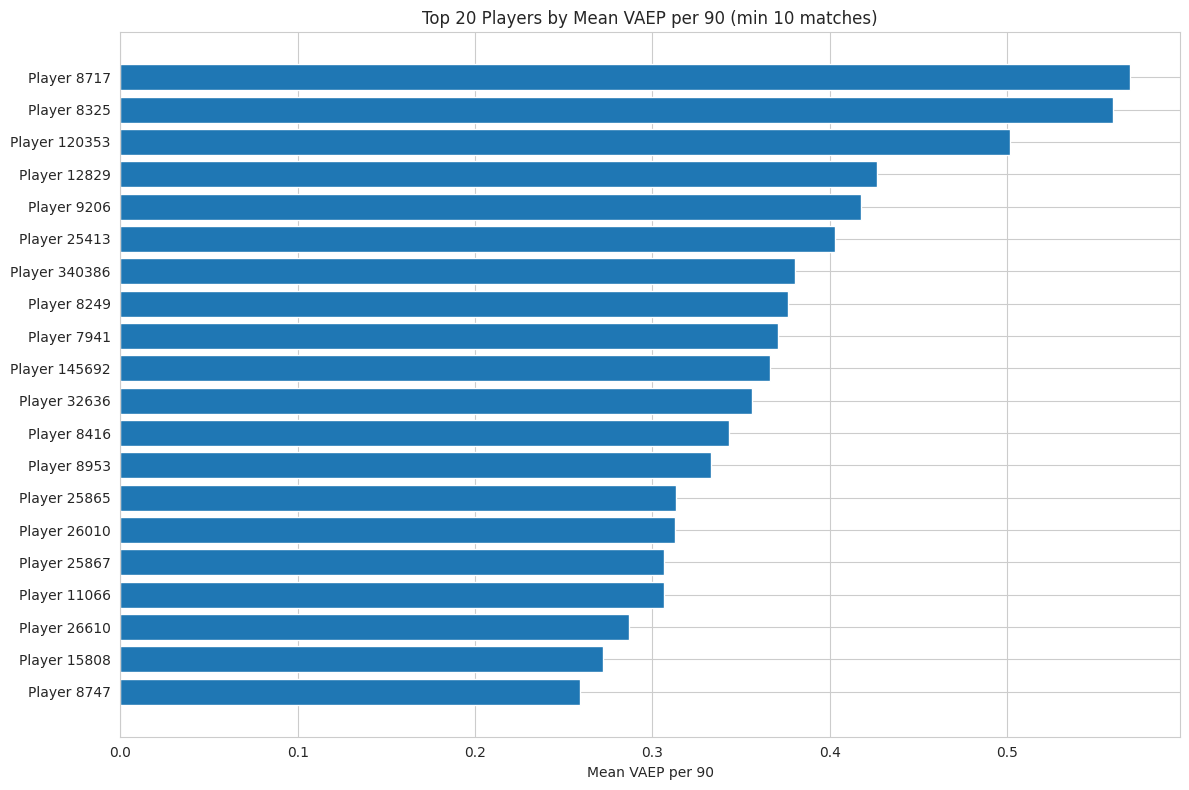

In [30]:
# Top 20 선수 시각화
plt.figure(figsize=(12, 8))
plt.barh(range(20), top_20_vaep_per90[vaep_col].values[::-1])
plt.yticks(range(20), [f"Player {pid}" for pid in top_20_vaep_per90['playerId'].values[::-1]])
plt.xlabel('Mean VAEP per 90')
plt.title(f'Top 20 Players by Mean VAEP per 90 (min {min_matches} matches)')
plt.tight_layout()
plt.show()

In [31]:
# Top 20 선수 (total VAEP 기준)
top_20_total_vaep = qualified_players.nlargest(20, total_col)

print("=" * 80)
print(f"Top 20 Players by Total VAEP (min {min_matches} matches)")
print("=" * 80)
print(top_20_total_vaep[['playerId', total_col, vaep_col, matches_col, events_col]].to_string(index=False))

Top 20 Players by Total VAEP (min 10 matches)
 playerId  season_vaep_total  season_vaep_per90_avg  matches_played  num_events
     8717          21.056098               0.569021              37        1857
   120353          16.058066               0.501538              36        2132
    12829          15.794448               0.426877              37        1301
     8325          13.995449               0.559839              25        1296
     8416          12.003595               0.343307              35        1663
    15808          10.053036               0.271905              37        2323
   340386          10.014427               0.380202              29        1158
    25413           9.979813               0.402708              32        1458
    11066           8.074036               0.306443              33        2184
     9123           8.040207               0.251287              36        1594
     7941           8.018356               0.370994              27       

## 5. VAEP vs 경기/이벤트 수 상관관계

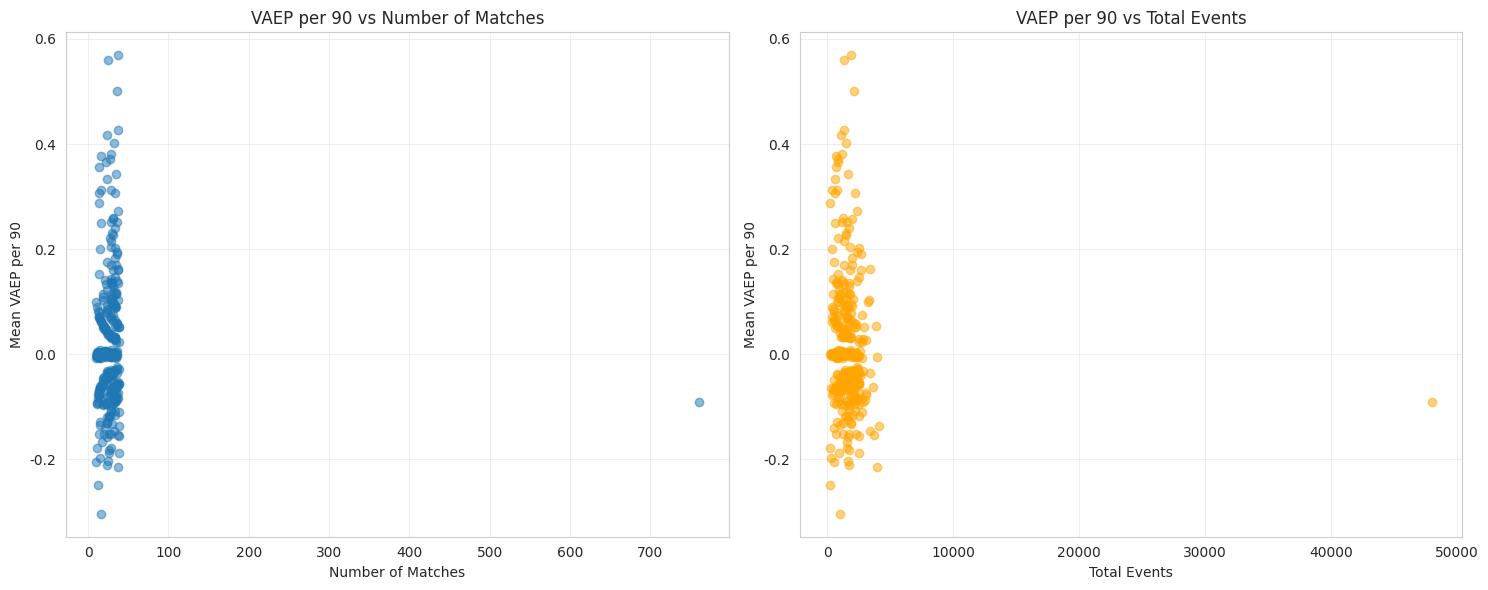

Correlation (Matches vs VAEP per 90): -0.0189
Correlation (Events vs VAEP per 90): -0.0826


In [32]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# VAEP per 90 vs 경기 수
axes[0].scatter(qualified_players[matches_col], qualified_players[vaep_col], alpha=0.5)
axes[0].set_xlabel('Number of Matches')
axes[0].set_ylabel('Mean VAEP per 90')
axes[0].set_title('VAEP per 90 vs Number of Matches')
axes[0].grid(True, alpha=0.3)

# VAEP per 90 vs 이벤트 수
axes[1].scatter(qualified_players[events_col], qualified_players[vaep_col], alpha=0.5, color='orange')
axes[1].set_xlabel('Total Events')
axes[1].set_ylabel('Mean VAEP per 90')
axes[1].set_title('VAEP per 90 vs Total Events')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 상관계수 계산
corr_matches = qualified_players[[matches_col, vaep_col]].corr().iloc[0, 1]
corr_events = qualified_players[[events_col, vaep_col]].corr().iloc[0, 1]

print(f"Correlation (Matches vs VAEP per 90): {corr_matches:.4f}")
print(f"Correlation (Events vs VAEP per 90): {corr_events:.4f}")

## 6. 경기당 VAEP 변동성 분석

In [33]:
# 경기가 10개 이상인 선수들의 VAEP 변동성 계산
player_variability = player_match_df.groupby('playerId').agg({
    'vaep_per90': ['mean', 'std', 'count']
}).reset_index()

player_variability.columns = ['playerId', 'mean_vaep_per90', 'std_vaep_per90', 'num_matches']
player_variability = player_variability[player_variability['num_matches'] >= min_matches].copy()
player_variability['cv'] = player_variability['std_vaep_per90'] / player_variability['mean_vaep_per90'].abs()

print("=" * 80)
print("VAEP Variability Analysis")
print("=" * 80)
print(f"\nMean standard deviation: {player_variability['std_vaep_per90'].mean():.4f}")
print(f"Median standard deviation: {player_variability['std_vaep_per90'].median():.4f}")

VAEP Variability Analysis

Mean standard deviation: 0.3871
Median standard deviation: 0.3728


In [34]:
# Most consistent players (낮은 표준편차)
most_consistent = player_variability.nsmallest(10, 'std_vaep_per90')
print("\nTop 10 Most Consistent Players (lowest std):")
print(most_consistent[['playerId', 'mean_vaep_per90', 'std_vaep_per90', 'num_matches']].to_string(index=False))

# Most variable players (높은 표준편차)
most_variable = player_variability.nlargest(10, 'std_vaep_per90')
print("\nTop 10 Most Variable Players (highest std):")
print(most_variable[['playerId', 'mean_vaep_per90', 'std_vaep_per90', 'num_matches']].to_string(index=False))


Top 10 Most Consistent Players (lowest std):
 playerId  mean_vaep_per90  std_vaep_per90  num_matches
     3424        -0.000242        0.001868           16
   397174         0.001617        0.001938           12
    86308        -0.001606        0.002313           16
     8488         0.001670        0.002591           32
     8142        -0.002758        0.002904           10
     8135        -0.006019        0.002949           11
     4365        -0.003896        0.003069           11
    14688         0.000303        0.003133           21
   240070        -0.001124        0.003133           16
   240559        -0.003297        0.003152           12

Top 10 Most Variable Players (highest std):
 playerId  mean_vaep_per90  std_vaep_per90  num_matches
    26010         0.312982        1.136029           29
   145692         0.366274        1.094896           22
   120353         0.501538        1.079079           36
   245364        -0.003420        1.044471           32
     8325    

## 7. 경기별 VAEP 추이 (샘플 선수)

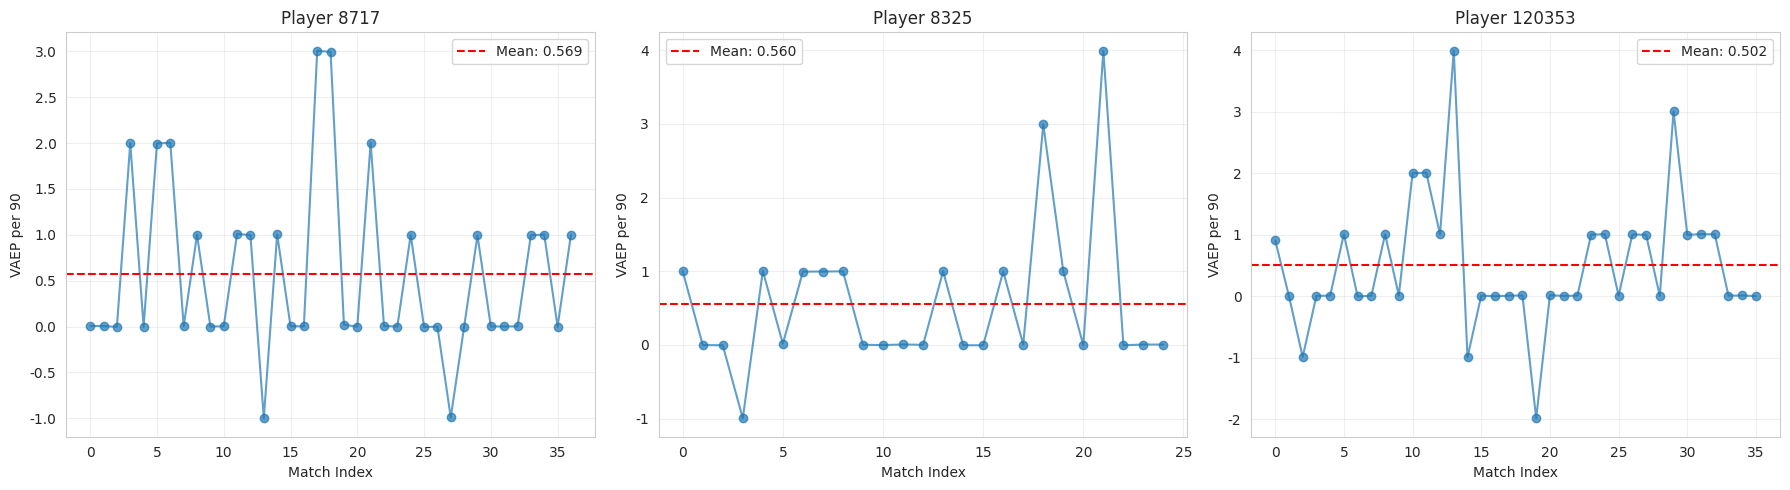

In [35]:
# Top 선수 3명의 경기별 VAEP 추이
top_3_players = top_20_vaep_per90.head(3)['playerId'].values

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, player_id in enumerate(top_3_players):
    player_matches = player_match_df[player_match_df['playerId'] == player_id].sort_values('matchId')
    
    axes[idx].plot(range(len(player_matches)), player_matches['vaep_per90'].values, marker='o', linestyle='-', alpha=0.7)
    axes[idx].axhline(player_matches['vaep_per90'].mean(), color='red', linestyle='--', label=f'Mean: {player_matches["vaep_per90"].mean():.3f}')
    axes[idx].set_xlabel('Match Index')
    axes[idx].set_ylabel('VAEP per 90')
    axes[idx].set_title(f'Player {player_id}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 요약 통계

In [ ]:
# 골키퍼 vs 필드 플레이어 비교
if len(gk_season_df) > 0:
    field_players_df = player_season_df[player_season_df['role'] != 'GK'].copy()
    
    # 최소 경기 수 필터
    gk_qualified = gk_season_df[gk_season_df[matches_col] >= min_matches]
    field_qualified = field_players_df[field_players_df[matches_col] >= min_matches]
    
    if len(gk_qualified) > 0 and len(field_qualified) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Goalkeeper vs Field Players Comparison', fontsize=16, fontweight='bold')
        
        # VAEP per 90 비교
        data_to_plot = [field_qualified[vaep_col].values, gk_qualified[vaep_col].values]
        bp = axes[0].boxplot(data_to_plot, labels=['Field Players', 'Goalkeepers'], patch_artist=True)
        bp['boxes'][0].set_facecolor('skyblue')
        bp['boxes'][1].set_facecolor('red')
        axes[0].set_ylabel('VAEP per 90')
        axes[0].set_title('VAEP per 90 Distribution')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # 통계 비교
        comparison_stats = pd.DataFrame({
            'Metric': ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max'],
            'Field Players': [
                len(field_qualified),
                field_qualified[vaep_col].mean(),
                field_qualified[vaep_col].median(),
                field_qualified[vaep_col].std(),
                field_qualified[vaep_col].min(),
                field_qualified[vaep_col].max()
            ],
            'Goalkeepers': [
                len(gk_qualified),
                gk_qualified[vaep_col].mean(),
                gk_qualified[vaep_col].median(),
                gk_qualified[vaep_col].std(),
                gk_qualified[vaep_col].min(),
                gk_qualified[vaep_col].max()
            ]
        })
        
        axes[1].axis('tight')
        axes[1].axis('off')
        table = axes[1].table(cellText=comparison_stats.values,
                             colLabels=comparison_stats.columns,
                             cellLoc='center',
                             loc='center',
                             colWidths=[0.3, 0.35, 0.35])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # 헤더 스타일
        for i in range(len(comparison_stats.columns)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # 데이터 행 스타일
        for i in range(1, len(comparison_stats) + 1):
            table[(i, 0)].set_facecolor('#f0f0f0')
            table[(i, 1)].set_facecolor('#e6f2ff')
            table[(i, 2)].set_facecolor('#ffe6e6')
        
        axes[1].set_title('Statistical Comparison', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "=" * 80)
        print("Goalkeeper vs Field Players Statistical Test")
        print("=" * 80)
        from scipy import stats
        statistic, pvalue = stats.mannwhitneyu(field_qualified[vaep_col], gk_qualified[vaep_col], alternative='two-sided')
        print(f"Mann-Whitney U test:")
        print(f"  - Statistic: {statistic:.2f}")
        print(f"  - P-value: {pvalue:.6f}")
        print(f"  - Significant difference: {'Yes' if pvalue < 0.05 else 'No'} (α=0.05)")
    else:
        print("\n⚠️ 비교할 충분한 데이터가 없습니다.")
else:
    print("\n⚠️ 골키퍼 데이터가 없습니다.")

In [ ]:
# 골키퍼 Top 20
if len(gk_season_df) > 0:
    gk_qualified = gk_season_df[gk_season_df[matches_col] >= min_matches].copy()
    
    if len(gk_qualified) > 0:
        top_gk = gk_qualified.nlargest(min(20, len(gk_qualified)), vaep_col)
        
        print(f"\n최소 {min_matches}경기 출전 골키퍼: {len(gk_qualified):,}명")
        print("\n" + "=" * 80)
        print(f"Top {len(top_gk)} Goalkeepers by Mean VAEP per 90")
        print("=" * 80)
        print(top_gk[['playerId', vaep_col, total_col, matches_col, events_col]].to_string(index=False))
        
        # 골키퍼 시각화
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Goalkeeper VAEP Analysis', fontsize=16, fontweight='bold')
        
        # VAEP per 90 분포
        axes[0].hist(gk_qualified[vaep_col], bins=20, edgecolor='black', alpha=0.7, color='red')
        axes[0].axvline(gk_qualified[vaep_col].median(), color='blue', linestyle='--', 
                       label=f'Median: {gk_qualified[vaep_col].median():.3f}', linewidth=2)
        axes[0].set_xlabel('VAEP per 90')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Goalkeeper VAEP per 90 Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Top 골키퍼 바 차트
        top_n = min(10, len(top_gk))
        axes[1].barh(range(top_n), top_gk[vaep_col].values[:top_n][::-1], color='red', alpha=0.7)
        axes[1].set_yticks(range(top_n))
        axes[1].set_yticklabels([f"GK {pid}" for pid in top_gk['playerId'].values[:top_n][::-1]])
        axes[1].set_xlabel('Mean VAEP per 90')
        axes[1].set_title(f'Top {top_n} Goalkeepers')
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n⚠️ 최소 {min_matches}경기 이상 출전한 골키퍼가 없습니다.")
else:
    print("\n⚠️ 골키퍼 데이터가 없습니다.")

In [ ]:
# 골키퍼만 필터링
gk_season_df = player_season_df[player_season_df['role'] == 'GK'].copy()
gk_match_df = player_match_df[player_match_df['role'] == 'GK'].copy()

print("=" * 80)
print("골키퍼(Goalkeeper) 전용 분석")
print("=" * 80)
print(f"\n총 골키퍼 수: {len(gk_season_df):,}")
print(f"총 골키퍼-경기 조합: {len(gk_match_df):,}")

if len(gk_season_df) > 0:
    print(f"\n골키퍼 VAEP 통계:")
    print(f"  - Mean VAEP per 90: {gk_season_df[vaep_col].mean():.4f} ± {gk_season_df[vaep_col].std():.4f}")
    print(f"  - Median VAEP per 90: {gk_season_df[vaep_col].median():.4f}")
    print(f"  - Min VAEP per 90: {gk_season_df[vaep_col].min():.4f}")
    print(f"  - Max VAEP per 90: {gk_season_df[vaep_col].max():.4f}")
else:
    print("\n⚠️ 골키퍼 데이터가 없습니다.")

## 9. 골키퍼 전용 분석

In [36]:
print("=" * 80)
print("VAEP Pipeline Results Summary")
print("=" * 80)

print(f"\n데이터셋 정보:")
print(f"  - 총 선수 수: {player_season_df['playerId'].nunique():,}")
print(f"  - 총 경기 수: {player_match_df['matchId'].nunique():,}")
print(f"  - 총 선수-경기 조합: {len(player_match_df):,}")
print(f"  - {min_matches}경기 이상 출전 선수: {len(qualified_players):,}")

print(f"\nVAEP 통계 (전체):")
print(f"  - Mean VAEP per 90: {player_season_df[vaep_col].mean():.4f} ± {player_season_df[vaep_col].std():.4f}")
print(f"  - Median VAEP per 90: {player_season_df[vaep_col].median():.4f}")
print(f"  - Min VAEP per 90: {player_season_df[vaep_col].min():.4f}")
print(f"  - Max VAEP per 90: {player_season_df[vaep_col].max():.4f}")

print(f"\nVAEP 통계 ({min_matches}경기 이상):")
print(f"  - Mean VAEP per 90: {qualified_players[vaep_col].mean():.4f} ± {qualified_players[vaep_col].std():.4f}")
print(f"  - Median VAEP per 90: {qualified_players[vaep_col].median():.4f}")
print(f"  - Min VAEP per 90: {qualified_players[vaep_col].min():.4f}")
print(f"  - Max VAEP per 90: {qualified_players[vaep_col].max():.4f}")

print("\n분석 완료!")

VAEP Pipeline Results Summary

데이터셋 정보:
  - 총 선수 수: 477
  - 총 경기 수: 380
  - 총 선수-경기 조합: 10,412
  - 10경기 이상 출전 선수: 360

VAEP 통계 (전체):
  - Mean VAEP per 90: 0.0057 ± 0.1513
  - Median VAEP per 90: -0.0004
  - Min VAEP per 90: -1.0045
  - Max VAEP per 90: 1.0034

VAEP 통계 (10경기 이상):
  - Mean VAEP per 90: 0.0179 ± 0.1273
  - Median VAEP per 90: -0.0014
  - Min VAEP per 90: -0.3043
  - Max VAEP per 90: 0.5690

분석 완료!


In [ ]:
# 전체 선수 랭킹 (Top 50)
print("=" * 100)
print("Overall Player Rankings (All Positions)")
print("=" * 100)

# 최소 경기 수 필터
all_qualified = player_season_df[player_season_df[matches_col] >= min_matches].copy()
top_50_overall = all_qualified.nlargest(50, vaep_col)

print(f"\n최소 {min_matches}경기 이상 출전 선수: {len(all_qualified):,}명")
print(f"\nTop 50 Players (All Positions):")
print("-" * 100)
print(top_50_overall[['playerId', 'role', vaep_col, total_col, matches_col, events_col]].to_string(index=False))

# Top 50 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Top 50 Players - All Positions', fontsize=16, fontweight='bold')

# 1. 바 차트
colors_top50 = ['red' if role == 'GK' else 'skyblue' for role in top_50_overall['role']]
axes[0].barh(range(50), top_50_overall[vaep_col].values[::-1], color=colors_top50[::-1], alpha=0.7)
axes[0].set_yticks(range(50))
axes[0].set_yticklabels([f"{role} {pid}" for role, pid in 
                         zip(top_50_overall['role'].values[::-1], top_50_overall['playerId'].values[::-1])], 
                        fontsize=7)
axes[0].set_xlabel('Mean VAEP per 90', fontsize=12)
axes[0].set_title('Top 50 Players by VAEP per 90', fontsize=13)
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Total VAEP vs VAEP per 90
axes[1].scatter(top_50_overall.loc[top_50_overall['role'] != 'GK', total_col],
               top_50_overall.loc[top_50_overall['role'] != 'GK', vaep_col],
               s=100, alpha=0.6, c='skyblue', label='Field Players', edgecolors='blue')
axes[1].scatter(top_50_overall.loc[top_50_overall['role'] == 'GK', total_col],
               top_50_overall.loc[top_50_overall['role'] == 'GK', vaep_col],
               s=150, alpha=0.8, c='red', label='Goalkeepers', marker='^', edgecolors='darkred')

# Top 5에 레이블 추가
for idx, (_, row) in enumerate(top_50_overall.head(5).iterrows()):
    axes[1].annotate(f"#{idx+1}\n{row['role']} {row['playerId']}", 
                    xy=(row[total_col], row[vaep_col]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=8, ha='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

axes[1].set_xlabel('Total VAEP', fontsize=12)
axes[1].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[1].set_title('Top 50: Total VAEP vs VAEP per 90', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 포지션별 VAEP 분포 (역할 코드별)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('VAEP Distribution by Role', fontsize=16, fontweight='bold')

# 역할별 그룹화
role_groups = player_season_df.groupby('role')

# 1. 역할별 VAEP per 90 박스플롯
roles = player_season_df['role'].value_counts().index.tolist()
role_data = [player_season_df[player_season_df['role'] == role][vaep_col].values for role in roles]

bp = axes[0, 0].boxplot(role_data, labels=roles, patch_artist=True)
colors = ['red' if role == 'GK' else 'skyblue' for role in roles]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 0].set_xlabel('Role', fontsize=12)
axes[0, 0].set_ylabel('VAEP per 90', fontsize=12)
axes[0, 0].set_title('VAEP per 90 by Role', fontsize=13)
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. 역할별 평균 VAEP 바 차트
role_means = player_season_df.groupby('role')[vaep_col].agg(['mean', 'count']).sort_values('mean', ascending=False)
colors_bar = ['red' if idx == 'GK' else 'skyblue' for idx in role_means.index]
axes[0, 1].bar(range(len(role_means)), role_means['mean'].values, color=colors_bar, alpha=0.7)
axes[0, 1].set_xticks(range(len(role_means)))
axes[0, 1].set_xticklabels(role_means.index, rotation=45)
axes[0, 1].set_xlabel('Role', fontsize=12)
axes[0, 1].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[0, 1].set_title('Average VAEP per 90 by Role', fontsize=13)
axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 각 바 위에 선수 수 표시
for i, (idx, row) in enumerate(role_means.iterrows()):
    axes[0, 1].text(i, row['mean'], f"n={int(row['count'])}", 
                   ha='center', va='bottom' if row['mean'] >= 0 else 'top', fontsize=9)

# 3. 전체 선수 VAEP 히스토그램 (역할별 색상)
for role in roles:
    role_data = player_season_df[player_season_df['role'] == role][vaep_col]
    color = 'red' if role == 'GK' else 'skyblue'
    alpha = 0.7 if role == 'GK' else 0.5
    axes[1, 0].hist(role_data, bins=30, alpha=alpha, label=f'{role} (n={len(role_data)})', 
                   color=color, edgecolor='black')

axes[1, 0].axvline(player_season_df[vaep_col].median(), color='green', linestyle='--', 
                  label=f'Overall Median: {player_season_df[vaep_col].median():.3f}', linewidth=2)
axes[1, 0].set_xlabel('VAEP per 90', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('VAEP per 90 Distribution by Role', fontsize=13)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 4. 역할별 통계 테이블
role_stats = player_season_df.groupby('role')[vaep_col].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
role_stats = role_stats.round(4)

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for idx, row in role_stats.iterrows():
    table_data.append([idx] + row.tolist())

table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Role', 'Count', 'Mean', 'Median', 'Std', 'Min', 'Max'],
                        cellLoc='center',
                        loc='center',
                        colWidths=[0.12, 0.12, 0.15, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# 헤더 스타일
for i in range(7):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# 데이터 행 스타일
for i in range(1, len(table_data) + 1):
    for j in range(7):
        if table_data[i-1][0] == 'GK':
            table[(i, j)].set_facecolor('#ffe6e6')
        else:
            table[(i, j)].set_facecolor('#e6f2ff' if i % 2 == 0 else 'white')

axes[1, 1].set_title('Statistical Summary by Role', fontsize=13, pad=20)

plt.tight_layout()
plt.show()

print("\n역할별 통계:")
print(role_stats.to_string())

In [ ]:
# 전체 선수 VAEP per 90 vs 경기 수 산점도
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('All Players VAEP Analysis', fontsize=16, fontweight='bold')

# 골키퍼와 필드 플레이어 분리
gk_mask = player_season_df['role'] == 'GK'
field_mask = player_season_df['role'] != 'GK'

# 1. VAEP per 90 vs Matches Played
axes[0].scatter(player_season_df.loc[field_mask, matches_col], 
               player_season_df.loc[field_mask, vaep_col],
               alpha=0.5, s=30, c='skyblue', label='Field Players', edgecolors='none')
axes[0].scatter(player_season_df.loc[gk_mask, matches_col], 
               player_season_df.loc[gk_mask, vaep_col],
               alpha=0.7, s=50, c='red', label='Goalkeepers', marker='^', edgecolors='darkred')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Matches Played', fontsize=12)
axes[0].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[0].set_title(f'All Players: VAEP per 90 vs Matches (n={len(player_season_df)})', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. VAEP per 90 vs Total Events
axes[1].scatter(player_season_df.loc[field_mask, events_col], 
               player_season_df.loc[field_mask, vaep_col],
               alpha=0.5, s=30, c='skyblue', label='Field Players', edgecolors='none')
axes[1].scatter(player_season_df.loc[gk_mask, events_col], 
               player_season_df.loc[gk_mask, vaep_col],
               alpha=0.7, s=50, c='red', label='Goalkeepers', marker='^', edgecolors='darkred')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Total Events', fontsize=12)
axes[1].set_ylabel('Mean VAEP per 90', fontsize=12)
axes[1].set_title(f'All Players: VAEP per 90 vs Events (n={len(player_season_df)})', fontsize=13)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n선수 분포:")
print(f"  - 필드 플레이어: {field_mask.sum():,}명")
print(f"  - 골키퍼: {gk_mask.sum():,}명")
print(f"  - 총 선수: {len(player_season_df):,}명")

## 10. 전체 선수 시각화 (All Players Plot)